# Face Detection & Emotion Recognition using DeepFace

This notebook demonstrates face detection and emotion recognition using the DeepFace library.

**Objectives:**
- Detect faces in images using multiple detection backends
- Crop and export face regions
- Classify facial expressions into 7 emotion categories
- Process videos with face detection and emotion analysis

**Library:** [DeepFace](https://github.com/serengil/deepface)

**Emotions:** happy, sad, angry, neutral, surprise, fear, disgust

## 1. Setup & Installation

In [ ]:
# Install required packages (run once)
# !pip install deepface tf-keras opencv-python matplotlib pandas tqdm

In [1]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

from deepface import DeepFace

# Set up paths
PROJECT_ROOT = Path("../")
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "faces"
CROPPED_DIR = OUTPUT_DIR / "cropped"
EMOTIONS_DIR = OUTPUT_DIR / "emotions"

# Create directories
CROPPED_DIR.mkdir(parents=True, exist_ok=True)
EMOTIONS_DIR.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully!")
print(f"DeepFace version: {DeepFace.__version__}")

Libraries imported successfully!
DeepFace version: 0.0.96


In [2]:
# Available face detection backends
AVAILABLE_BACKENDS = [
    'opencv',      # Fast, low accuracy
    'ssd',         # Fast, medium accuracy
    'mtcnn',       # Medium speed, good accuracy (SELECTED DEFAULT)
    'retinaface',  # Slow, best accuracy
    'mediapipe',   # Fast, good accuracy
    'yolov8',      # Medium speed, good accuracy
    'yunet',       # Fast, good accuracy
    'centerface'   # Fast, good accuracy
]

# Default backend (MTCNN - good balance for CPU)
DEFAULT_BACKEND = 'mtcnn'

# Emotion categories
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print(f"Default backend: {DEFAULT_BACKEND}")
print(f"Emotion categories: {EMOTIONS}")

Default backend: mtcnn
Emotion categories: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


## 2. Download Sample Images

In [3]:
# Download sample images for testing
import urllib.request

sample_images = {
    "zidane.jpg": "https://ultralytics.com/images/zidane.jpg",
    "bus.jpg": "https://ultralytics.com/images/bus.jpg"
}

images_dir = DATA_DIR / "images"
images_dir.mkdir(parents=True, exist_ok=True)

for filename, url in sample_images.items():
    filepath = images_dir / filename
    if not filepath.exists():
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
    else:
        print(f"{filename} already exists")

print("\nSample images ready!")

zidane.jpg already exists
bus.jpg already exists

Sample images ready!


## 3. Face Detection

In [4]:
def detect_faces(image_path, detector_backend=DEFAULT_BACKEND, align=True, enforce_detection=False):
    """
    Detect faces in an image using DeepFace.
    
    Args:
        image_path: Path to input image
        detector_backend: Face detection backend to use
        align: Whether to align faces
        enforce_detection: Raise error if no face detected
    
    Returns:
        face_objs: List of face objects with face image and coordinates
    """
    try:
        face_objs = DeepFace.extract_faces(
            img_path=str(image_path),
            detector_backend=detector_backend,
            align=align,
            enforce_detection=enforce_detection
        )
        return face_objs
    except Exception as e:
        print(f"Error detecting faces: {e}")
        return []

In [5]:
# Detect faces in sample image
image_path = DATA_DIR / "images" / "zidane.jpg"
print(f"Detecting faces in: {image_path.name}")
print(f"Using backend: {DEFAULT_BACKEND}")

face_objs = detect_faces(image_path)

print(f"\nDetected {len(face_objs)} face(s)")
for i, face in enumerate(face_objs):
    area = face['facial_area']
    confidence = face.get('confidence', 'N/A')
    print(f"\nFace {i}:")
    print(f"  Position: x={area['x']}, y={area['y']}")
    print(f"  Size: w={area['w']}, h={area['h']}")
    print(f"  Confidence: {confidence}")

Detecting faces in: zidane.jpg
Using backend: mtcnn

Detected 2 face(s)

Face 0:
  Position: x=903, y=101
  Size: w=134, h=175
  Confidence: 1.0

Face 1:
  Position: x=553, y=264
  Size: w=111, h=164
  Confidence: 1.0


In [6]:
def draw_face_boxes(image, face_objs, color=(0, 255, 0), thickness=2):
    """
    Draw bounding boxes around detected faces.
    
    Args:
        image: Image array (BGR)
        face_objs: List of face objects from DeepFace
        color: Box color (BGR)
        thickness: Line thickness
    
    Returns:
        image: Annotated image
    """
    img = image.copy()
    
    for i, face in enumerate(face_objs):
        area = face['facial_area']
        x, y, w, h = area['x'], area['y'], area['w'], area['h']
        
        # Draw rectangle
        cv2.rectangle(img, (x, y), (x + w, y + h), color, thickness)
        
        # Draw label
        label = f"Face {i}"
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img

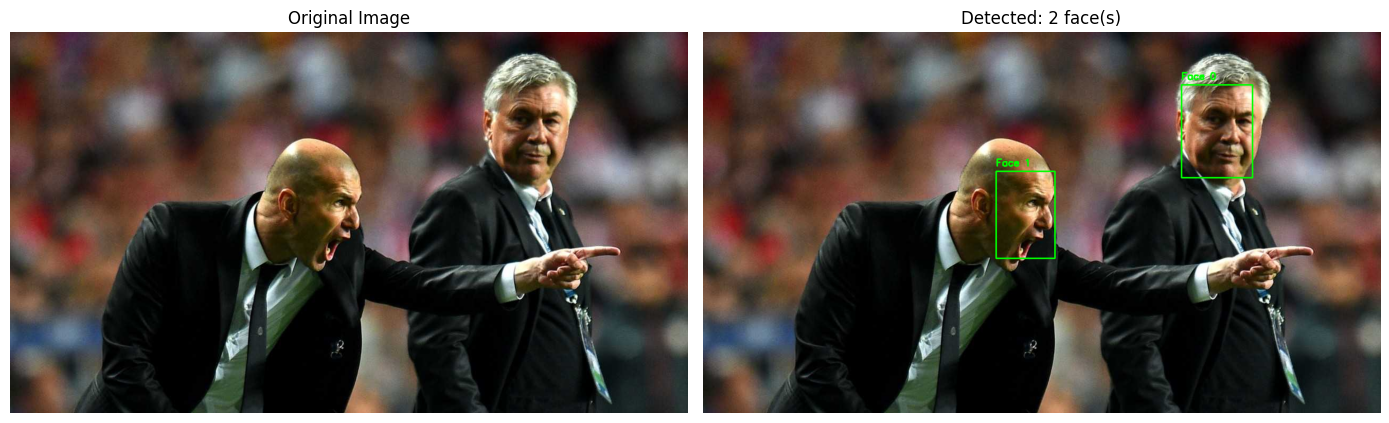

In [7]:
# Visualize detected faces
original = cv2.imread(str(image_path))
annotated = draw_face_boxes(original, face_objs)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
axes[1].set_title(f"Detected: {len(face_objs)} face(s)")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(CROPPED_DIR / "face_detection_result.png", dpi=150, bbox_inches='tight')
plt.show()

## 4. Compare Detection Backends

In [8]:
def compare_backends(image_path, backends=['opencv', 'mtcnn', 'retinaface', 'mediapipe']):
    """
    Compare different face detection backends.
    
    Args:
        image_path: Path to test image
        backends: List of backends to compare
    
    Returns:
        results: Dictionary of backend -> (num_faces, time_taken)
    """
    import time
    results = {}
    
    for backend in backends:
        print(f"Testing {backend}...", end=" ")
        try:
            start = time.time()
            faces = detect_faces(image_path, detector_backend=backend)
            elapsed = time.time() - start
            results[backend] = {
                'num_faces': len(faces),
                'time_ms': elapsed * 1000,
                'faces': faces
            }
            print(f"{len(faces)} faces, {elapsed*1000:.0f}ms")
        except Exception as e:
            print(f"Error: {e}")
            results[backend] = {'num_faces': 0, 'time_ms': 0, 'faces': [], 'error': str(e)}
    
    return results

In [9]:
# Compare backends (using subset for faster testing)
print("Comparing face detection backends...\n")
backend_results = compare_backends(
    image_path,
    backends=['opencv', 'mtcnn']
    #backends=['opencv', 'mtcnn', 'retinaface']
)

# Create comparison table
comparison_data = []
for backend, result in backend_results.items():
    comparison_data.append({
        'Backend': backend,
        'Faces Detected': result['num_faces'],
        'Time (ms)': f"{result['time_ms']:.0f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nBackend Comparison:")
print(df_comparison.to_string(index=False))

Comparing face detection backends...

Testing opencv... 1 faces, 187ms
Testing mtcnn... 2 faces, 310ms

Backend Comparison:
Backend  Faces Detected Time (ms)
 opencv               1       187
  mtcnn               2       310


## 5. Face Cropping & Export

In [10]:
def crop_and_save_faces(image_path, face_objs, output_dir, base_name=None, padding=20):
    """
    Crop detected faces and save as individual images.
    
    Args:
        image_path: Path to original image
        face_objs: List of face objects from DeepFace
        output_dir: Directory to save cropped faces
        base_name: Base name for output files
        padding: Padding around face region
    
    Returns:
        saved_paths: List of paths to saved face images
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    if base_name is None:
        base_name = Path(image_path).stem
    
    # Read original image
    image = cv2.imread(str(image_path))
    h, w = image.shape[:2]
    
    saved_paths = []
    
    for i, face in enumerate(face_objs):
        area = face['facial_area']
        x, y, fw, fh = area['x'], area['y'], area['w'], area['h']
        
        # Add padding
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(w, x + fw + padding)
        y2 = min(h, y + fh + padding)
        
        # Crop face
        face_crop = image[y1:y2, x1:x2]
        
        # Save
        save_path = output_dir / f"{base_name}_face_{i}.jpg"
        cv2.imwrite(str(save_path), face_crop)
        saved_paths.append(save_path)
        
        # Also save the aligned face from DeepFace (if available)
        if 'face' in face:
            aligned_face = face['face']
            # Convert from 0-1 float to 0-255 uint8 if needed
            if aligned_face.max() <= 1:
                aligned_face = (aligned_face * 255).astype(np.uint8)
            aligned_path = output_dir / f"{base_name}_face_{i}_aligned.jpg"
            # DeepFace returns RGB, convert to BGR for OpenCV
            if len(aligned_face.shape) == 3:
                aligned_bgr = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(aligned_path), aligned_bgr)
    
    return saved_paths

In [11]:
# Crop and save faces
saved_faces = crop_and_save_faces(
    image_path=image_path,
    face_objs=face_objs,
    output_dir=CROPPED_DIR,
    padding=30
)

print(f"Saved {len(saved_faces)} cropped face(s):")
for path in saved_faces:
    print(f"  - {path.name}")

Saved 2 cropped face(s):
  - zidane_face_0.jpg
  - zidane_face_1.jpg


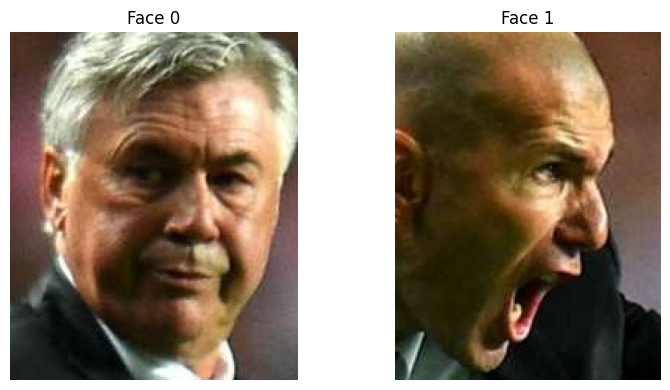

In [12]:
# Display cropped faces
if saved_faces:
    n_faces = len(saved_faces)
    fig, axes = plt.subplots(1, min(n_faces, 4), figsize=(4 * min(n_faces, 4), 4))
    if n_faces == 1:
        axes = [axes]
    
    for i, face_path in enumerate(saved_faces[:4]):
        face_img = cv2.imread(str(face_path))
        face_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(face_rgb)
        axes[i].set_title(f"Face {i}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(CROPPED_DIR / "cropped_faces_preview.png", dpi=150, bbox_inches='tight')
    plt.show()

## 6. Emotion Recognition

In [13]:
def analyze_emotions(image_path, detector_backend=DEFAULT_BACKEND, enforce_detection=False):
    """
    Analyze emotions in faces detected in an image.
    
    Args:
        image_path: Path to input image
        detector_backend: Face detection backend
        enforce_detection: Raise error if no face detected
    
    Returns:
        results: List of analysis results with emotion data
    """
    try:
        results = DeepFace.analyze(
            img_path=str(image_path),
            actions=['emotion'],
            detector_backend=detector_backend,
            enforce_detection=enforce_detection
        )
        return results
    except Exception as e:
        print(f"Error analyzing emotions: {e}")
        return []

In [14]:
# Analyze emotions in sample image
print(f"Analyzing emotions in: {image_path.name}")
print(f"Using backend: {DEFAULT_BACKEND}")

emotion_results = analyze_emotions(image_path)

print(f"\nAnalyzed {len(emotion_results)} face(s)")
for i, result in enumerate(emotion_results):
    print(f"\nFace {i}:")
    print(f"  Dominant emotion: {result['dominant_emotion'].upper()}")
    print(f"  Emotion scores:")
    for emotion, score in sorted(result['emotion'].items(), key=lambda x: x[1], reverse=True):
        bar = '=' * int(score / 5)
        print(f"    {emotion:10s}: {score:5.1f}% {bar}")

Analyzing emotions in: zidane.jpg
Using backend: mtcnn

Analyzed 2 face(s)

Face 0:
  Dominant emotion: NEUTRAL
  Emotion scores:
    neutral   :  93.7% ==================
    sad       :   5.9% =
    happy     :   0.2% 
    angry     :   0.1% 
    fear      :   0.1% 
    surprise  :   0.0% 
    disgust   :   0.0% 

Face 1:
  Dominant emotion: NEUTRAL
  Emotion scores:
    neutral   :  90.3% ==================
    sad       :   7.6% =
    happy     :   1.7% 
    fear      :   0.3% 
    angry     :   0.1% 
    surprise  :   0.0% 
    disgust   :   0.0% 


In [15]:
def draw_emotions(image, emotion_results, color=(0, 255, 0)):
    """
    Draw emotion labels on detected faces.
    
    Args:
        image: Image array (BGR)
        emotion_results: Results from DeepFace.analyze
        color: Label color (BGR)
    
    Returns:
        image: Annotated image
    """
    img = image.copy()
    
    # Emotion colors
    emotion_colors = {
        'happy': (0, 255, 0),      # Green
        'sad': (255, 0, 0),        # Blue
        'angry': (0, 0, 255),      # Red
        'fear': (255, 0, 255),     # Magenta
        'surprise': (0, 255, 255), # Yellow
        'disgust': (128, 0, 128),  # Purple
        'neutral': (128, 128, 128) # Gray
    }
    
    for i, result in enumerate(emotion_results):
        region = result['region']
        x, y, w, h = region['x'], region['y'], region['w'], region['h']
        
        dominant = result['dominant_emotion']
        score = result['emotion'][dominant]
        color = emotion_colors.get(dominant, (0, 255, 0))
        
        # Draw rectangle
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        
        # Draw emotion label with background
        label = f"{dominant} ({score:.0f}%)"
        (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(img, (x, y - text_h - 10), (x + text_w + 5, y), color, -1)
        cv2.putText(img, label, (x + 2, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    return img

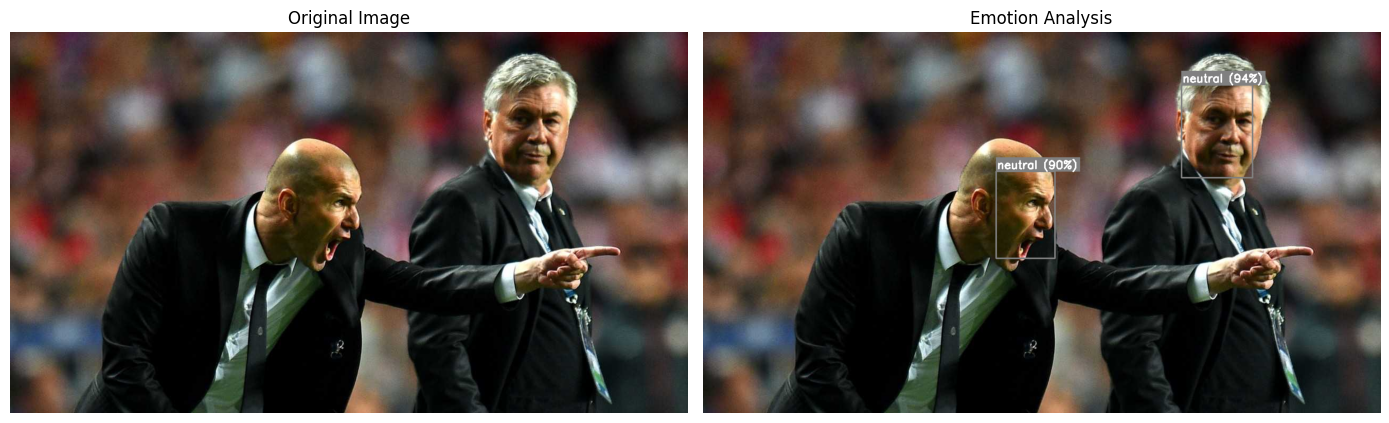

In [16]:
# Visualize emotion analysis
original = cv2.imread(str(image_path))
emotion_annotated = draw_emotions(original, emotion_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(emotion_annotated, cv2.COLOR_BGR2RGB))
axes[1].set_title("Emotion Analysis")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(EMOTIONS_DIR / "emotion_analysis_result.png", dpi=150, bbox_inches='tight')
plt.show()

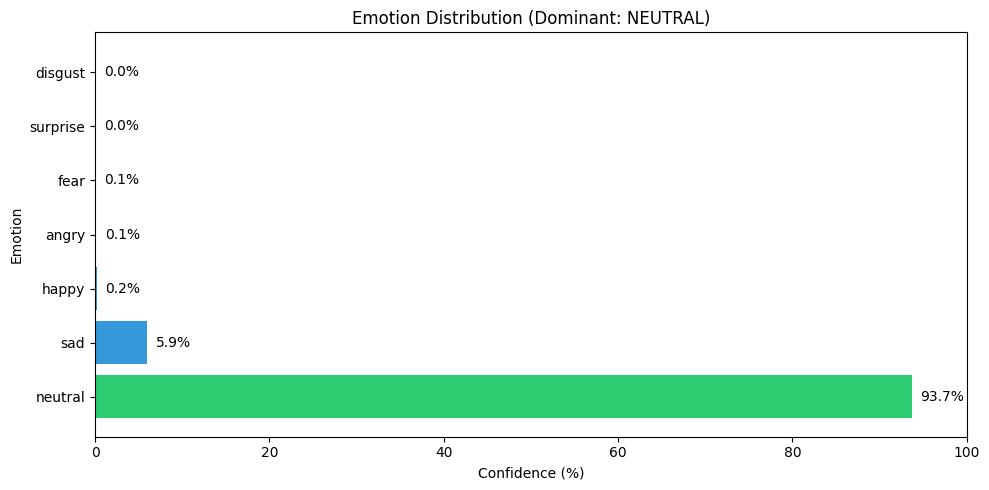

In [17]:
# Plot emotion distribution for first face
if emotion_results:
    result = emotion_results[0]
    emotions = result['emotion']
    
    # Sort by score
    sorted_emotions = dict(sorted(emotions.items(), key=lambda x: x[1], reverse=True))
    
    plt.figure(figsize=(10, 5))
    colors = ['#2ecc71' if e == result['dominant_emotion'] else '#3498db' for e in sorted_emotions.keys()]
    bars = plt.barh(list(sorted_emotions.keys()), list(sorted_emotions.values()), color=colors)
    plt.xlabel('Confidence (%)')
    plt.ylabel('Emotion')
    plt.title(f"Emotion Distribution (Dominant: {result['dominant_emotion'].upper()})")
    plt.xlim(0, 100)
    
    # Add value labels
    for bar, value in zip(bars, sorted_emotions.values()):
        plt.text(value + 1, bar.get_y() + bar.get_height()/2, f'{value:.1f}%', va='center')
    
    plt.tight_layout()
    plt.savefig(EMOTIONS_DIR / "emotion_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()

## 7. Video Processing

In [18]:
def process_video_emotions(video_path, output_path, detector_backend=DEFAULT_BACKEND, 
                           sample_every=1, conf_threshold=0.5):
    """
    Process video for face detection and emotion recognition.
    
    Args:
        video_path: Path to input video
        output_path: Path to save output video
        detector_backend: Face detection backend
        sample_every: Process every N frames (for speed)
        conf_threshold: Minimum confidence for face detection
    
    Returns:
        frame_results: List of per-frame emotion results
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Processing video: {video_path}")
    print(f"  Resolution: {width}x{height}, FPS: {fps}")
    print(f"  Total frames: {total_frames}")
    print(f"  Processing every {sample_every} frame(s)")
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    frame_results = []
    last_emotions = None
    
    for frame_idx in tqdm(range(total_frames), desc="Processing frames"):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Process every N frames
        if frame_idx % sample_every == 0:
            try:
                results = DeepFace.analyze(
                    img_path=frame,
                    actions=['emotion'],
                    detector_backend=detector_backend,
                    enforce_detection=False
                )
                last_emotions = results
            except:
                pass
        
        # Draw emotions on frame
        if last_emotions:
            frame = draw_emotions(frame, last_emotions)
            
            # Record stats
            frame_results.append({
                'frame': frame_idx,
                'num_faces': len(last_emotions),
                'emotions': [r['dominant_emotion'] for r in last_emotions]
            })
        else:
            frame_results.append({
                'frame': frame_idx,
                'num_faces': 0,
                'emotions': []
            })
        
        out.write(frame)
    
    cap.release()
    out.release()
    
    print(f"\nOutput saved to: {output_path}")
    return frame_results

Found 1 video(s). Processing first one...
Processing video: ../data/videos/Bangkok.mp4
  Resolution: 1280x720, FPS: 25
  Total frames: 650
  Processing every 3 frame(s)


Processing frames: 100%|██████████| 650/650 [01:19<00:00,  8.21it/s]


Output saved to: ../outputs/faces/emotions/Bangkok_emotions.mp4


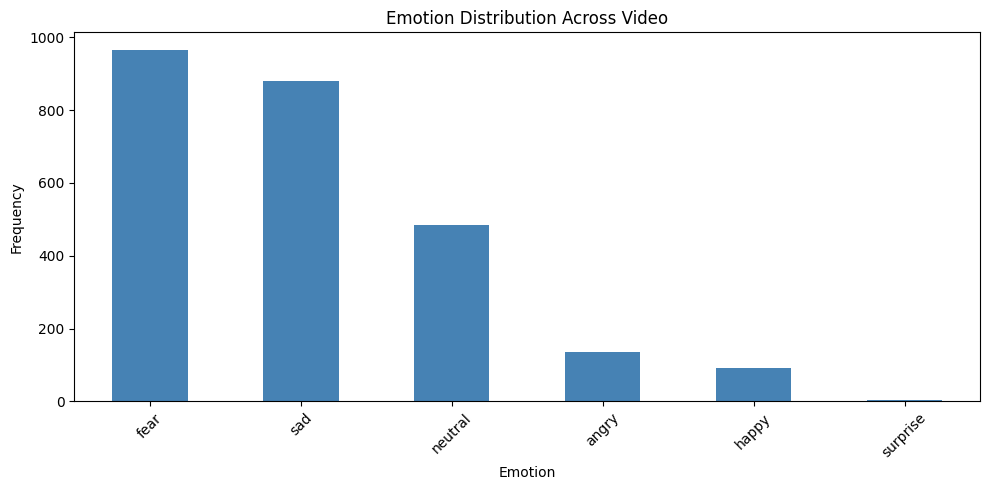

In [19]:
# Check for available videos
video_dir = DATA_DIR / "videos"
video_extensions = [".mp4", ".avi", ".mov", ".mkv"]
videos = [f for f in video_dir.iterdir() if f.suffix.lower() in video_extensions] if video_dir.exists() else []

if videos:
    print(f"Found {len(videos)} video(s). Processing first one...")
    video_path = videos[0]
    output_path = EMOTIONS_DIR / f"{video_path.stem}_emotions.mp4"
    
    frame_results = process_video_emotions(
        video_path=video_path,
        output_path=output_path,
        sample_every=3  # Process every 3rd frame for speed
    )
    
    # Analyze emotion distribution across video
    all_emotions = []
    for result in frame_results:
        all_emotions.extend(result['emotions'])
    
    if all_emotions:
        emotion_counts = pd.Series(all_emotions).value_counts()
        plt.figure(figsize=(10, 5))
        emotion_counts.plot(kind='bar', color='steelblue')
        plt.title('Emotion Distribution Across Video')
        plt.xlabel('Emotion')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(EMOTIONS_DIR / "video_emotion_distribution.png", dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("No videos found in data/videos/")
    print("Add video files to test video emotion analysis.")

## 8. Batch Processing

In [20]:
def batch_analyze_emotions(image_folder, detector_backend=DEFAULT_BACKEND):
    """
    Analyze emotions in all images in a folder.
    
    Args:
        image_folder: Path to folder containing images
        detector_backend: Face detection backend
    
    Returns:
        all_results: Dictionary of filename -> results
    """
    image_folder = Path(image_folder)
    image_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]
    image_files = [f for f in image_folder.iterdir() if f.suffix.lower() in image_extensions]
    
    all_results = {}
    
    print(f"Processing {len(image_files)} images...")
    for img_path in tqdm(image_files):
        try:
            results = analyze_emotions(img_path, detector_backend=detector_backend)
            all_results[img_path.name] = {
                'num_faces': len(results),
                'results': [{
                    'dominant_emotion': r['dominant_emotion'],
                    'emotion_scores': r['emotion']
                } for r in results]
            }
        except Exception as e:
            all_results[img_path.name] = {'num_faces': 0, 'error': str(e)}
    
    return all_results

In [21]:
# Process all images in data/images folder
batch_results = batch_analyze_emotions(DATA_DIR / "images")

print("\nBatch Processing Results:")
print("=" * 50)
for filename, result in batch_results.items():
    if 'error' in result:
        print(f"{filename}: Error - {result['error']}")
    else:
        emotions = [r['dominant_emotion'] for r in result['results']]
        print(f"{filename}: {result['num_faces']} face(s) - {emotions}")

Processing 3 images...


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Batch Processing Results:
inp.jpeg: 4 face(s) - ['neutral', 'angry', 'neutral', 'angry']
zidane.jpg: 2 face(s) - ['neutral', 'neutral']
bus.jpg: 2 face(s) - ['happy', 'neutral']


## 9. Export Results

In [ ]:
# Export batch results to JSON
json_path = EMOTIONS_DIR / "batch_emotion_results.json"
with open(json_path, 'w') as f:
    json.dump(batch_results, f, indent=2)
print(f"Results saved to: {json_path}")

# Export to CSV
csv_data = []
for filename, result in batch_results.items():
    if 'results' in result:
        for i, face_result in enumerate(result['results']):
            row = {
                'filename': filename,
                'face_id': i,
                'dominant_emotion': face_result['dominant_emotion']
            }
            row.update(face_result['emotion_scores'])
            csv_data.append(row)

if csv_data:
    df = pd.DataFrame(csv_data)
    csv_path = EMOTIONS_DIR / "batch_emotion_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"CSV saved to: {csv_path}")
    print("\nDataFrame preview:")
    display(df)

## 10. Custom Image Analysis

In [ ]:
# Example: Analyze emotions in a custom image
# Uncomment and modify the path below:

# custom_image = "/path/to/your/image.jpg"
# 
# # Detect and analyze
# results = analyze_emotions(custom_image)
# 
# # Display results
# img = cv2.imread(custom_image)
# annotated = draw_emotions(img, results)
# 
# plt.figure(figsize=(12, 8))
# plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
# plt.title(f"Detected {len(results)} face(s)")
# plt.axis('off')
# plt.show()
# 
# # Print emotion details
# for i, r in enumerate(results):
#     print(f"Face {i}: {r['dominant_emotion']} ({r['emotion'][r['dominant_emotion']]:.1f}%)")

## Summary

This notebook demonstrated:
1. **Face Detection** using DeepFace with multiple backends (opencv, mtcnn, retinaface, mediapipe)
2. **Backend Comparison** - speed vs accuracy tradeoffs
3. **Face Cropping** - extracting and saving individual faces
4. **Emotion Recognition** - classifying 7 emotions (happy, sad, angry, neutral, surprise, fear, disgust)
5. **Video Processing** - frame-by-frame emotion analysis
6. **Batch Processing** - analyzing multiple images
7. **Results Export** - JSON and CSV output

**Key Functions:**
- `DeepFace.extract_faces()` - Face detection and cropping
- `DeepFace.analyze(actions=['emotion'])` - Emotion recognition

**Default Backend:** MTCNN (good balance for CPU)

**Next Steps:**
- Integrate with person detection (YOLO → face detection within person bbox)
- Add face recognition for identity verification
- Real-time webcam emotion analysis